### Training Graph Results Visualisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
all_models_names = [
    ["BaseModel",  "FT - Incept CNN - LSTM"],
    ["PTBaseModel", "Incept CNN - LSTM"],
    ["AttnModel_Incept12FT", "FT - Incept CNN - Attn - LSTM"],
    ["AttnModel_InceptPT", "Incept CNN - Attn - LSTM"],
    ["AttnModel_Resnet20FT", "FT - Resnet50 CNN - Attn - LSTM"],
    ["AttnModel_ResnetPT", "Resnet50 CNN - Attn - LSTM"],
    ["TransformerModel_20FT", "FT - MaxViT - Transformer Decoder"],
    ["TransformerModel_PT", "MaxViT - Transformer Decoder"]
]

data_list = []

for (csv_file, model_name) in all_models_names:
    data = pd.read_csv(f'../../resources/training_results/{csv_file}.csv', index_col=0)
    data_list.append([data.loc[:75], model_name])

In [12]:
def visualise_results(data:list, y_axis:str):
    columns = data[0][0].columns
    if y_axis not in columns:
        raise Exception(f"Invalid y_axis, accepted y_axis: {data[0][0].columns}")
    
    plt.figure(figsize=(8, 6)) 

    for (df, model_name) in data:
        plt.plot(df[y_axis], label=model_name)
    
    plt.xlabel("Epoch")
    plt.ylabel(y_axis)
    plt.title(f"{y_axis} against epoch")
    plt.legend(fontsize=10)

    plt.show()

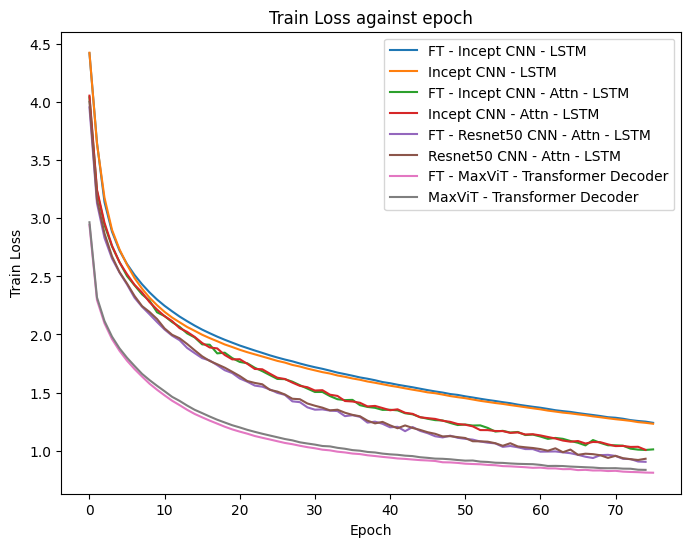

In [15]:
visualise_results(data_list, 'Train Loss')

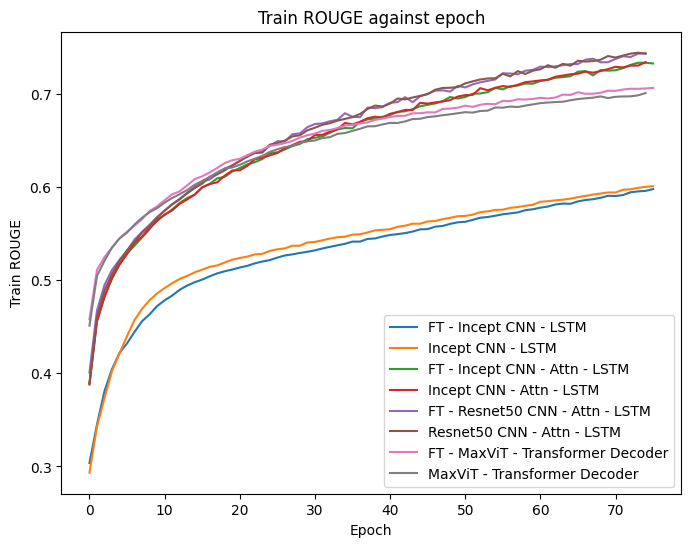

In [16]:
visualise_results(data_list, 'Train ROUGE')

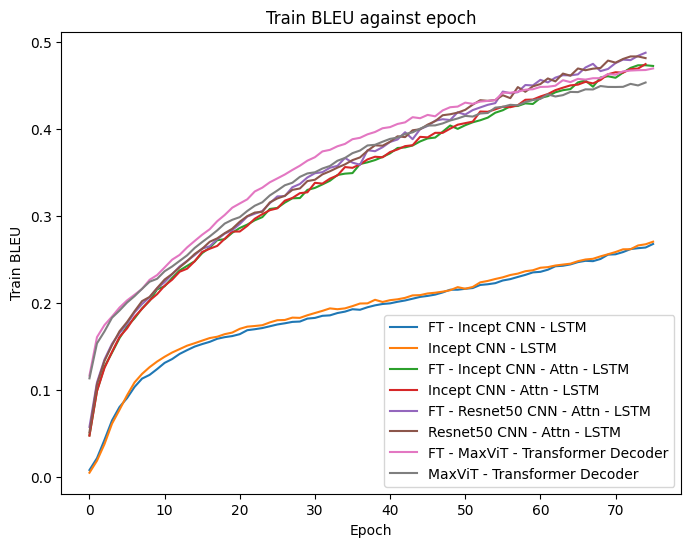

In [17]:
visualise_results(data_list, 'Train BLEU')

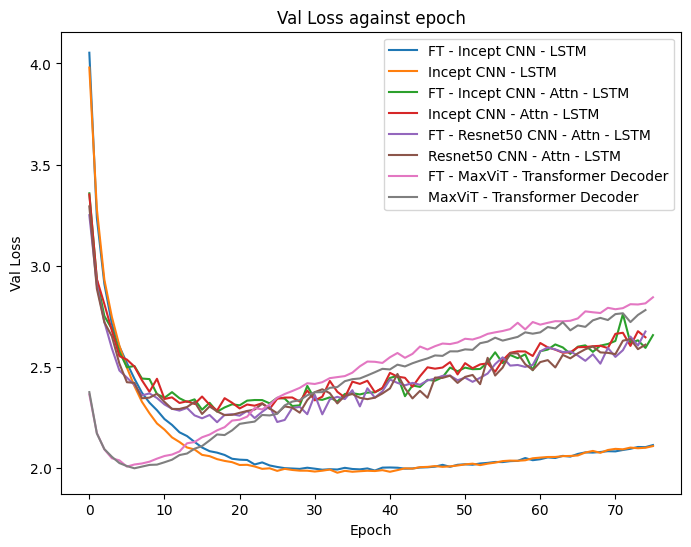

In [18]:
visualise_results(data_list, 'Val Loss')

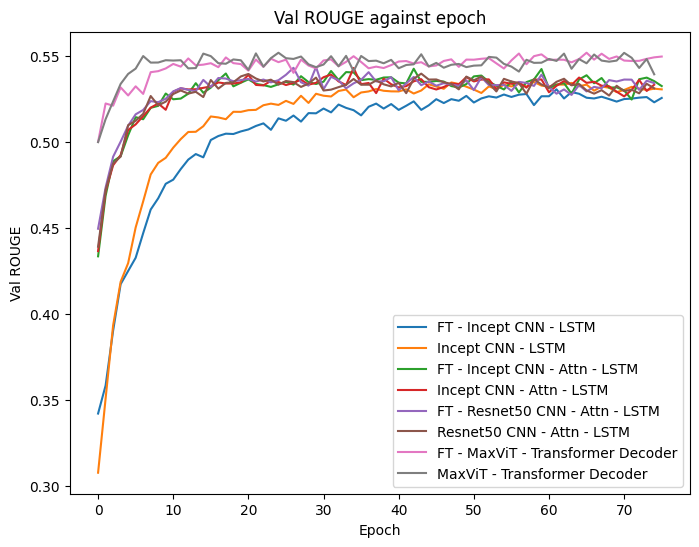

In [19]:
visualise_results(data_list, 'Val ROUGE')

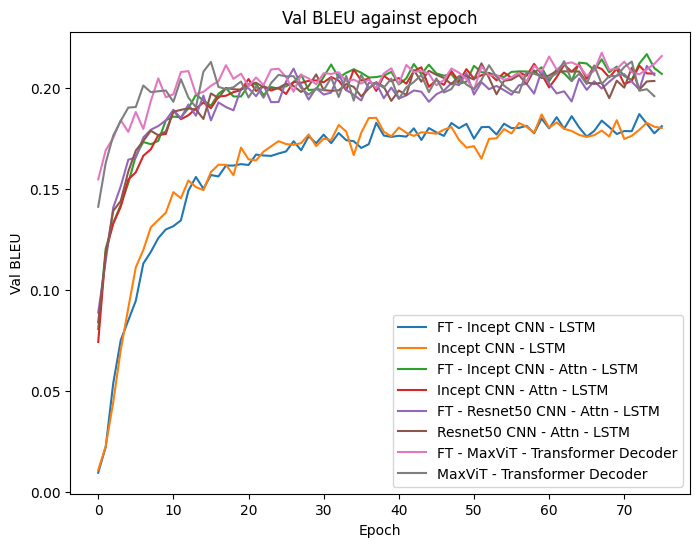

In [20]:
visualise_results(data_list, 'Val BLEU')

### Multiple Model Inference

#### Imports

In [56]:
#Imports
from PIL import Image, ImageOps
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import timm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import Tensor
import pickle

In [37]:
#Tokenizer to split sentences into a list of words
word_tokenizer = spacy.load("en_core_web_sm")


class Vocabulary():
  """
  Class to convert the captions to index sequential tensors

  Args:
    freq_threshold (int, optional): How many times a word has to appear in dataset before it can be added to the vocabulary. Defaults to 2

  """

  def __init__(self, freq_threshold:int=2):
    self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"} #index to sentence
    self.stoi = {"<PAD>": 0, "<SOS>":1, "<EOS>": 2, "<UNK>":3} #sentence to index
    self.freq_threshold = freq_threshold #threshold for adding a word to the vocab

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    #convert sentence to list of words
    return [tok.text.lower() for tok in word_tokenizer.tokenizer(text)] #convert sentence to words


  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4 #0-3 are for special tokens

    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence): #convert sentence to words
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1

        if frequencies[word] == self.freq_threshold: #once met freq_threshold, add to vocab list
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text) #convert annnotations to labels by converting each word to the index inside the vocab, else UNK tag
    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
        for token in tokenized_text
    ]

In [38]:
class CustomDataset(Dataset):

    """
    Class to setup the custom Dataset for pyTorch Dataloader

    Args:
        Note: the order of the csv_file and root_dir are directly related, csv_file[0] contains captions for images in root_dir[0]
        
        csv_file (list): Lists of path to CSV files with annotations.
        root_dir (list): List of directory containing images.
        img_size (tuple, optional): Image size in the format (width, height), defaults to (256,256)
        transform (callable, optional): Optional torchvision transform to be applied on a sample, defaults to None
        freq_threshold (int, optional): Freq threshold for Vocabulary Class, defaults to 2
        vocabulary (Vocabulary, optional): Determines to use an existing vocabulary or create own, defaults to None
    Returns:
        image: transformed image
        labels: tensor object of the labels
        all_image_captions: list containing all the captions of the image
    """

    def __init__(self, csv_file:list, root_dir:list, img_size:tuple=(256,256), transform=None, freq_threshold=2, vocabulary=None):
        
        #dataframe with col name ['image_filename', 'image_captions'] from csv file
        self.annotations = pd.DataFrame()
        #list containing the int boundary on which image path to look at
        #list will containing the num of images in directory which is the boundary
        self.root_dir_boundary = []
        
        for idx, label_files in enumerate(csv_file): 
            labels = pd.read_csv(label_files, index_col=0) #remove index col
            self.annotations = pd.concat([self.annotations, labels], ignore_index=True) #merging annotations into 1 dataset

            #getting the image boundary on which idx belongs to which image file path
            if idx == 0: 
                self.root_dir_boundary.append(len(labels))
            else:
                #get the number of images in root directory and add with the previous to get the range of index that are in this filepath
                self.root_dir_boundary.append(self.root_dir_boundary[idx-1] + len(labels))

        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        #initialise vocabulary
        if vocabulary == None:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.annotations.iloc[:,1].to_list()) #build vocab with all captions
        else:
            self.vocab = vocabulary

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.annotations.iloc[idx, 0] #Image name as column 0
        #finding the correct root directory filepath in the list does the image belong to
        image_dir_idx = 0
        while idx >= self.root_dir_boundary[image_dir_idx] and image_dir_idx < len(self.root_dir_boundary):
            image_dir_idx += 1

        img_path = f"{self.root_dir[image_dir_idx]}/{img_name}"

        image = Image.open(img_path)
        # image = ImageOps.pad(image, self.img_size) #resize image
        annotation = self.annotations.iloc[idx, 1] #Annotation as column 1
        
        #converting caption to index tensor
        numercalized_annotations = [self.vocab.stoi["<SOS>"]]
        numercalized_annotations += self.vocab.numericalize(annotation)
        numercalized_annotations.append(self.vocab.stoi["<EOS>"])

        #create list of all captions associated with the image (for BLEU & ROUGE score)
        all_img_captions = self.annotations[self.annotations['image_filename'] == img_name]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(numercalized_annotations), all_img_captions.iloc[:,1].to_list()


In [39]:
class padAnnotations():
  """
  Collate function to pad all caption to the same length as max(len(caption)) in a batch

  Args:
    pad_idx (int): Index Label for the <PAD> token
    batch_first (boolean, optional): Decide if the dataset labels should be batch first
                                     Either returns (batch size, seq length) or (seq length, batch size)
  
  Returns:
    img: batch image object
    labels: batch of tensors of the captions, converted to the same length by adding <PAD>
    all_labels: batch of lists of the captions of the images
  """
  def __init__(self, pad_idx, batch_first = False):
    self.batch_first = batch_first
    self.pad_idx = pad_idx

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch] 
    imgs = torch.cat(imgs, dim=0)
    labels = [item[1] for item in batch]
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=self.batch_first, padding_value=self.pad_idx)
    all_labels = [item[2] for item in batch]

    return imgs, labels, all_labels

In [40]:
#Parameter Setup
image_size = (299,299)
batch_size = 64

In [41]:
#Define transforms for image preprocessing
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(num_magnitude_bins=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

#No data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

In [42]:
def load_vocab(filepath:str):
        file = open(filepath, 'rb')
        vocab = pickle.load(file)
        if isinstance(vocab, Vocabulary):
            print("Vocabulary Loaded Successfully")
            return vocab
        else:
            raise Exception("Invalid Vocabulary")
        
vocab = load_vocab('../../resources/Vocabulary.pkl')

Vocabulary Loaded Successfully


In [43]:
test_dataset = CustomDataset(csv_file=['../../input/Landscape/Test/Labels/Blip_Label_Clean.csv', '../../input/Landscape/Test/Labels/Kosmos_Label_Clean.csv'],
                        root_dir=['../../input/Landscape/Test/Images', '../../input/Landscape/Test/Images'],
                        transform=eval_transform,
                        img_size=image_size,
                        vocabulary=vocab)

test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = vocab.stoi["<PAD>"],
                            batch_first=False
                        ))

In [44]:
# CNN encoder (using inceptionV3)
class EncoderCNN(torch.nn.Module):
  """
  InceptionV3 CNN Encoder Model, last layer is always trainable

  Args:
      finetuned_model: Finetuned InceptionV3 model, else None
      embed_size (int): Embedding dimension to convert features size to
      train_CNN (bool, optional): Determines if the entire CNN model will be unfreeze and trained during the training
  """
  def __init__(self, finetuned_model, embed_size:int, train_CNN:bool=False):
    super(EncoderCNN, self).__init__()
    #load pre-trained model
    if finetuned_model != None:
        self.inception = list(finetuned_model.children())[0]
    else:
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
    self.inception.aux_logits = False

    #converting the last layer of inception to linear layer [inception last layer input, embed size]
    self.inception.fc = torch.nn.Linear(self.inception.fc.in_features, embed_size) 
    #Train the feature map, the rest depends on train_CNN
    for name, param in self.inception.named_parameters():
      if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True #finetuning the last layer
      else:
        param.requires_grad = train_CNN

    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.5)


  def forward(self, images):
    features = self.inception(images)
    return self.dropout(self.relu(features))
  

class DecoderRNN(torch.nn.Module):
  """
  LSTM decoder model

  Args:
      embed_size (int): Embedding dimension to embed words
      hidden_size (int): Hidden state dimension for LSTM
      vocab_size (int): Total number of unique vocab
      num_layers (int): Total number of LSTM layers
  """
  def __init__(self, embed_size:int, hidden_size:int, vocab_size:int, num_layers:int):
    super(DecoderRNN, self).__init__()
    self.embed = torch.nn.Embedding(vocab_size, embed_size) #embed / tokenize the word
    self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers)
    self.linear = torch.nn.Linear(hidden_size, vocab_size)  #classification layer
    self.dropout = torch.nn.Dropout(0.5)

  def forward(self, features, captions):
    embeddings = self.dropout(self.embed(captions))
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)

    hiddens, _ = self.lstm(embeddings)
    outputs = self.linear(hiddens)
    return outputs
  

class CNNtoRNN(torch.nn.Module):
  """
  Model that merges Encoder CNN to Decoder RNN

  Args:
      embed_size (int): Embedding dimension to embed words
      hidden_size (int): Hidden state dimension for LSTM
      vocab_size (int): Total number of unique vocab
      num_layers (int): Total number of LSTM layers
      train_cnn (bool, optional): Determines if unfreezing entire InceptionV3 model, defaults to False
  """
  def __init__(self, finetuned_model, embed_size:int, hidden_size:int, vocab_size:int, num_layers:int, train_cnn:bool=False):
    super(CNNtoRNN, self).__init__()
    self.encoderCNN = EncoderCNN(finetuned_model, embed_size, train_cnn)
    self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

  #for training with a caption
  def forward(self, images, captions):
    features = self.encoderCNN(images)
    outputs = self.decoderRNN(features, captions)
    return outputs

  #for prediction where there is a semi caption and they have to continue the caption
  def caption_image(self, image, vocabulary, device, max_length=50):
    result_caption = []

    with torch.no_grad(): #no training
      x = self.encoderCNN(image.to(device)).unsqueeze(0) #image as input
      states = None

      for _ in range(max_length):
        hiddens, states = self.decoderRNN.lstm(x, states) #image is the initial state for the LSTM
        output = self.decoderRNN.linear(hiddens.squeeze(0)) #get the output from the LSTM for the first word
        predicted = output.argmax(1) #first word

        result_caption.append(predicted.item())
        x = self.decoderRNN.embed(predicted).unsqueeze(0) #update the input to the lstm to now be the first word

        if vocabulary.itos[predicted.item()] == "<EOS>":
          break

    return [vocabulary.itos[idx] for idx in result_caption], None  #get the string from the vocabulary instead of the indices, no attention



In [45]:
class InceptionV3EncoderCNN(torch.nn.Module):
    """
    InceptionV3 CNN Encoder Model, feature extraction layer (mixed_7c) is always trainable

    Args:
        finetuned_model: Finetuned inceptionV3 model, else None
        train_cnn (bool, optional): Determines if the entire CNN model will be unfreeze and trained during the training. Defaults to False.
    """
    def __init__(self, finetuned_model, train_cnn:bool=False):
        super(InceptionV3EncoderCNN, self).__init__()
        if finetuned_model != None:
            self.inception = list(finetuned_model.children())[0]
        
        else:
            self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        self.inception.aux_logits = False
        
        #Remove last classification layer
        self.inception.fc = torch.nn.Identity()

        #Variable that will hold the features
        self.features = None
        
        #Register the hook to capture features at output of last CNN layer
        self.inception.Mixed_7c.register_forward_hook(self.capture_features_hook)

        #Train the feature map, the rest depends on train_CNN
        for name, param in self.inception.named_parameters():
            if 'Mixed_7c' in name:
                param.requires_grad_(True)
            else:
                param.requires_grad_(train_cnn)


    def capture_features_hook(self, module, input, output):
        self.features = output #update feature 


    def forward(self, images):
        """
        Take images and return feature maps of size (batch, height*width)
        """
        _ = self.inception(images)  #Pass through the inception network
        batch, feature_maps, size_1, size_2 = self.features.size()  #self.features contain the feature map of size (batch size, 2048, 8,8)
        features = self.features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps) #resize to (batch size, h*w, feature_maps)

        return features
        
class ResNetEncoderCNN(torch.nn.Module):
    """
    ResNet50 CNN Encoder Model, feature extraction layer (fc) is always trainable

    Args:
        finetuned_model: Finetuned inceptionV3 model, else None
        train_cnn (bool, optional): Determines if the entire CNN model will be unfreeze and trained during the training
    """
    def __init__(self, finetuned_model, train_cnn:bool=False):
        super(ResNetEncoderCNN, self).__init__()

        if finetuned_model != None:
            resnet = list(finetuned_model.children())[0]
        else:
            resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        #Train the feature map, the rest depends on train_CNN
        for name, param in resnet.named_parameters(): 
            if "layer4.2.conv3.weight" in name:
                param.requires_grad_(True)
            else:
                param.requires_grad_(train_cnn)
        
        modules = list(resnet.children())[:-2]
        self.resnet = torch.nn.Sequential(*modules)
        
    def forward(self, images):
        """
        Take images and return feature maps of size (batch, height*width)
        """
        features = self.resnet(images)
        # first, we need to resize the tensor to be 
        # (batch, h*w, feature_maps)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
       
        return features

class BahdanauAttention(torch.nn.Module):
    """
    Adaptive Attention Module

    Args:
        feature_dim (int): Dimension of feature maps (h*w)
        hidden_dim (int): Dimension of hidden states
        output_dim (int, optional): Dimension of output, default to 1
    """
    def __init__(self, feature_dim:int, hidden_dim:int, output_dim:int = 1):
        super(BahdanauAttention, self).__init__()
         # fully-connected layer to learn first weight matrix Wa
        self.W_a = torch.nn.Linear(feature_dim, hidden_dim)
        # fully-connected layer to learn the second weight matrix Ua
        self.U_a = torch.nn.Linear(hidden_dim, hidden_dim)
        # fully-connected layer to produce score (output), learning weight matrix va
        self.v_a = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, features, hidden_state):
        """
        Args:
            features: image features from Encoder
            hidden_state: hidden state output for Decoder

        Returns:
            context: context vector with size (1,2048)
            atten_weights: probabilities of feature relevance 
        """
        #add additional dimension to a hidden (required for summation) 
        hidden_state = hidden_state.unsqueeze(1) #(batch size, 1, seq length)

        atten_1 = self.W_a(features) #(batch size, h*w, hidden_dim)
        atten_2 = self.U_a(hidden_state) #(batch size, 1, hidden_dim)

        #apply tangent to combine result from 2 fc layers
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan) #(batch size, hidden_dim)
        atten_weight = torch.nn.functional.softmax(atten_score, dim = 1) #get softmax probablilities

        #multiply each vector with its softmax score and sum to get attention context vector
        context = torch.sum(atten_weight * features,  dim = 1) #size of context equals to a number of feature maps
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight
    
class LSTMDecoderRNN(torch.nn.Module):
     """
     LSTM decoder model

     Args:
          feature_dim (int): Feature Map dimension (h*w)
          embed_size (int): Embedding dimension to embed words
          hidden_size (int): Hidden state dimension for LSTM
          vocab_size (int): Total number of unique vocab
          drop_prob (float, optional): Dropout layer probability, deafults to 0.5
          sample_temp (float, optional): Scale outputs before softmax to allow the model to be more picky as the differences are exaggerated. Defaults to 0.5
     """
     def __init__(self, feature_dim:int, embedding_dim:int, hidden_dim:int, vocab_size:int, drop_prob:float=0.5, sample_temp:float=0.5):
          super(LSTMDecoderRNN, self).__init__()
          
          self.feature_dim = feature_dim
          self.embedding_dim = embedding_dim
          self.hidden_dim = hidden_dim
          self.vocab_size = vocab_size
          self.sample_temp = sample_temp #scale the outputs b4 softmax

          #layers

          #embedding layer that turns words into index 
          self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
          #lstm layer that takes in feature + embedding (image + caption) and output hidden_dim
          self.lstm = torch.nn.LSTMCell(embedding_dim + feature_dim, hidden_dim)
          #fc linear layer that predicts next word
          self.fc = torch.nn.Linear(hidden_dim, vocab_size)
          #attention layer
          self.attention = BahdanauAttention(feature_dim, hidden_dim)
          #dropout layer
          self.drop = torch.nn.Dropout(p=drop_prob)
          #initialisation of fully-connected layers
          self.init_h = torch.nn.Linear(feature_dim, hidden_dim) #initiialising hidden state and cell memory using avg of feature
          self.init_c = torch.nn.Linear(feature_dim, hidden_dim)

     def init_hidden(self, features):
          """
          Initializes hidden state and cell memory using average feature vector
          Args:
               features: feature map of the image
          Returns:
               h0: initial hidden state (short-term memory)
               c0: initial cell state (long-term memory)
          """
          mean_annotations = torch.mean(features, dim = 1) #getting average of the features
          h0 = self.init_h(mean_annotations)
          c0 = self.init_c(mean_annotations)
          return h0, c0

     def forward(self, features, captions, device:str, sample_prob:float=0.2):
          """
          Args:
               features: feature map of image
               captions: true caption of image
               device (str): cuda or cpu
               sample_prob (float, optional): Probability for auto-regressive RNN where they train on RNN output rather than true layer, defaults to 0.2

          """
          embed = self.embeddings(captions)
          h,c = self.init_hidden(features)
          batch_size = captions.size(0) #captions: (batch size, seq length)
          seq_len = captions.size(1) 
          feature_size = features.size(1) #features: (batch size, size, 2048)

          #storage of outputs and attention weights of lstm
          outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
          atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)

          #scheduled sampling for training, using the models output to train instead of using the true output
          #autoregressive RNN training, only when length of seq > 1 (cannot be first word)
          for t in range(seq_len):
               s_prob = 0.0 if t==0 else sample_prob
               use_sampling = np.random.random() < s_prob

               if not use_sampling: #no sampling
                    word_embeddings = embed[:, t, :] #embedding until word t
               
               context, atten_weight = self.attention(features,h)
               inputs = torch.cat([word_embeddings, context], 1) #embed captions and features for next lstm state
               h, c = self.lstm(inputs, (h,c)) #pass through lstm
               output = self.fc(self.drop(h))
               
               if use_sampling: #using predicted word instead of true output
                    scaled_output = output/self.sample_temp #using scaling temp to amplify the values
                    #this way softmax will have a larger difference in values
                    #makes the model more selective of whats its picking 
                    
                    scoring = torch.nn.functional.log_softmax(scaled_output, dim=1)
                    top_idx = scoring.topk(1)[1]
                    word_embeddings = self.embeddings(top_idx).squeeze(1) #update word embeddings with predicted instead of actual
               
               #update results
               outputs[:,t,:] = output
               atten_weights[:, t, :] = atten_weight

          return outputs, atten_weights


class InceptV3EncoderAttentionDecoder(torch.nn.Module):
    """
    InceptionV3 Encoder with Attention and LSTM Decoder

    Args:
        finetuned_model: Finetuned InceptionV3 model, else None
        feature_dim (int): Feature Map dimension (h*w)
        embedding_dim (int): Embedding dimension to embed words
        hidden_dim (int): Hidden state dimension for LSTM
        vocab_size (int): Total number of unique vocab
        device (str): cuda or cpu
        train_cnn (boolean, optional): Determines if inceptionCNN model is unfreezed. Defaults to False.
        drop_prob (float, optional): Dropout layer probability. Defaults to 0.5.
        sample_temp (float, optional): Scale outputs before softmax to allow the model to be more picky as the differences are exaggerated. Defaults to 0.5
    """
    def __init__(self, finetuned_model, feature_dim:int, embedding_dim:int, hidden_dim:int, vocab_size:int, device:str, train_cnn:bool=False, drop_prob:float=0.5, sample_temp:float=0.5):
        super(InceptV3EncoderAttentionDecoder, self).__init__()
        self.encoder = InceptionV3EncoderCNN(finetuned_model, train_cnn)
        self.decoder= LSTMDecoderRNN(feature_dim, embedding_dim, hidden_dim, vocab_size, drop_prob, sample_temp)
        self.sample_temp = sample_temp
        self.device = device

    def forward(self, image, captions):
        features = self.encoder(image)
        outputs, atten_weights = self.decoder(features, captions, self.device, self.sample_temp)
        return outputs, atten_weights
    

    #for inference
    def caption_image(self, image, vocabulary:Vocabulary, device:str, max_length:int=50):
        """
        Generate caption using a greedy algorithm based on image input

        Args:
            image: image input
            vocabulary (Vocabulary): Vocabulary to decode predictions
            device (str): cuda or cpu
            max_length (int, optional): Max length of generated captions. Defaults to 50.

        Returns:
            captions: string caption in a list
            atten_weights: probabilities of feature relevance 
        """
        self.encoder.eval()

        result_caption = []
        result_weights = []

        with torch.no_grad(): #no training
            input_word = torch.tensor(1).unsqueeze(0).to(device)
            result_caption.append(1)
            features = self.encoder(image)
            h, c = self.decoder.init_hidden(features)

            for _ in range(max_length):
                embedded_word = self.decoder.embeddings(input_word)
                context, atten_weight = self.decoder.attention(features, h)
                # input_concat shape at time step t = (batch, embedding_dim + context size)
                input_concat = torch.cat([embedded_word, context],  dim = 1)
                h, c = self.decoder.lstm(input_concat, (h,c))
                h = self.decoder.drop(h)
                output = self.decoder.fc(h) 
                scoring = torch.nn.functional.log_softmax(output, dim=1)
                top_idx = scoring[0].topk(1)[1]
                result_caption.append(top_idx.item())
                result_weights.append(atten_weight)
                input_word = top_idx

                if (len(result_caption) >= max_length or vocabulary.itos[input_word.item()] == "<EOS>"):
                    break

            return [vocabulary.itos[idx] for idx in result_caption], result_weights

class ResNetEncoderAttentionDecoder(torch.nn.Module):
    """
    Resnet50 Encoder with Attention and LSTM Decoder

    Args:
        finetuned_model: Finetuned InceptionV3 model, else None
        feature_dim (int): Feature Map dimension (h*w)
        embedding_dim (int): Embedding dimension to embed words
        hidden_dim (int): Hidden state dimension for LSTM
        vocab_size (int): Total number of unique vocab
        device (str): cuda or cpu
        train_cnn (boolean, optional): Determines if inceptionCNN model is unfreezed. Defaults to False.
        drop_prob (float, optional): Dropout layer probability. Defaults to 0.5.
        sample_temp (float, optional): Scale outputs before softmax to allow the model to be more picky as the differences are exaggerated. Defaults to 0.5
    """
    def __init__(self, finetuned_model, feature_dim:int, embedding_dim:int, hidden_dim:int, vocab_size:int, device:str, train_cnn:bool=False, drop_prob:float=0.5, sample_temp:float=0.5):
        super(ResNetEncoderAttentionDecoder, self).__init__()
        self.encoder = ResNetEncoderCNN(finetuned_model, train_cnn)
        self.decoder= LSTMDecoderRNN(feature_dim, embedding_dim, hidden_dim, vocab_size, drop_prob, sample_temp)
        self.sample_temp = sample_temp
        self.device = device

    def forward(self, image, captions):
        features = self.encoder(image)
        outputs, atten_weights = self.decoder(features, captions, self.device, self.sample_temp)
        return outputs, atten_weights
    

    #for inference
    def caption_image(self, image, vocabulary:Vocabulary, device:str, max_length:int=50):
        """
        Generate caption using a greedy algorithm based on image input

        Args:
            image: image input
            vocabulary (Vocabulary): Vocabulary to decode predictions
            device (str): cuda or cpu
            max_length (int, optional): Max length of generated captions. Defaults to 50.

        Returns:
            captions: string caption in a list
            atten_weights: probabilities of feature relevance 
        """
        self.encoder.eval()

        result_caption = []
        result_weights = []

        with torch.no_grad(): #no training
            input_word = torch.tensor(1).unsqueeze(0).to(device)
            result_caption.append(1)
            features = self.encoder(image)
            h, c = self.decoder.init_hidden(features)

            for _ in range(max_length):
                embedded_word = self.decoder.embeddings(input_word)
                context, atten_weight = self.decoder.attention(features, h)
                # input_concat shape at time step t = (batch, embedding_dim + context size)
                input_concat = torch.cat([embedded_word, context],  dim = 1)
                h, c = self.decoder.lstm(input_concat, (h,c))
                h = self.decoder.drop(h)
                output = self.decoder.fc(h) 
                scoring = torch.nn.functional.log_softmax(output, dim=1)
                top_idx = scoring[0].topk(1)[1]
                result_caption.append(top_idx.item())
                result_weights.append(atten_weight)
                input_word = top_idx

                if (len(result_caption) >= max_length or vocabulary.itos[input_word.item()] == "<EOS>"):
                    break

            return [vocabulary.itos[idx] for idx in result_caption], result_weights


In [46]:
class EncoderMaxVit(torch.nn.Module):
  """
    An encoder module based on the MaxVit architecture, adapted for image captioning by converting images into dense feature embeddings.

    The final fully connected (fc) layer of the MaxVit model is replaced to map the extracted features to the desired embedding size.
    Feature extraction layer (classifier.5 for pretrained and head for finetuned) is always trainable.

    Args:
      finetuned_model: Finetuned MaxVit model, else None
      embedding_size (int): Embedding Dimension for size of feature embedding
      train_CNN (bool, optional): Determines if the entire MaxVit model will be unfreeze and trained during the training. Defaults to False.
      drop_p (float, optional): Dropout probability to use in the dropout layer for regularization. Defaults to 0.5.
  """
  
  def __init__(self, finetuned_model, embedding_size:int, train_CNN:bool=False, drop_p:float=0.5):
    super(EncoderMaxVit, self).__init__()
    self.embed_size = embedding_size

    if finetuned_model is not None:
      # Initialize custom finetuned model and make the last linear layer trainable
      self.model = list(finetuned_model.children())[0]
      self.model.classifier[-1] = torch.nn.Linear(in_features=self.model.classifier[-1].in_features, out_features=self.embed_size, bias=True)
      #Remove creating feature extraction layer and make it trainable, the rest depends on train_cnn
      for name, param in self.model.named_parameters():
        if "classifier.5.weight" in name or "classifier.5.bias" in name:
          param.requires_grad = True
        else:
          param.requires_grad = train_CNN

    else:
      # Initialize pretrained model and make last linear layer trainable
      model_used = 'maxvit_rmlp_tiny_rw_256.sw_in1k'
      self.model = timm.create_model(model_used, pretrained=True)
      self.model.head.fc = torch.nn.Linear(in_features=self.model.head.fc.in_features, out_features=self.embed_size, bias=True)

      for name , param in self.model.named_parameters():
        if "head.fc.weight" in name or "head.fc.bias" in name:
          param.requires_grad = True
        else:
          param.requires_grad = train_CNN

    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(drop_p)
    
              
  def forward(self, image):
    output = self.model(image)
    output = self.dropout(self.relu(output))
    
    return output
  
class PositionalEncoding(torch.nn.Module):
  """
    Injects some information about the relative or absolute position of the tokens in the sequence.
    Embeddings do not encode the relative position of tokens in a sentence. 
    With positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sequence, in the d-dimensional space.

    Args:
      d_model (int): The dimension of the embeddings.
      dropout (float, optional): The dropout probability.
      max_len (int, optional): The maximum length of the input sequences.
  """
  
  def __init__(self, d_model: int, dropout: float=0.1, max_len: int=5000):
    super().__init__()

    self.dropout = torch.nn.Dropout(p=dropout)
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    """
      Args:
        x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)
  

class TransformersDecoder(torch.nn.Module):
  """
    A Transformer-based decoder that generates captions from image features. 
    Uses the features from the encoder as the memory input to the Transformer layers,
    along with the target tokens (captions) which are shifted right.
    It applies positional encoding to the target token embeddings to maintain their sequence information.

    Args:
      embedding_size (int): The size of the embedding vector for each token.
      trg_vocab_size (int): The size of the target vocabulary.
      num_heads (int): The number of heads in the multihead-attention models.
      num_decoder_layers (int): The number of sub-decoder-layers in the decoder.
      dropout (float): The dropout probability.

    The decoder generates predictions for the next token in the sequence, given the current sequence of tokens and the image features.
  """
   
  def __init__(self, embedding_size:int, trg_vocab_size:int, num_heads:int, num_decoder_layers:int, dropout:float):
    super(TransformersDecoder, self).__init__()
    self.num_heads = num_heads

    self.embedding = torch.nn.Embedding(trg_vocab_size, embedding_size)
    self.pos = PositionalEncoding(d_model=embedding_size)
    self.decoder_layer = torch.nn.TransformerDecoderLayer(d_model=embedding_size, nhead=num_heads)
    self.decoder = torch.nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
    self.linear = torch.nn.Linear(embedding_size, trg_vocab_size)
    self.drop = torch.nn.Dropout(dropout)
      
  def make_mask(self, sz):
    """
      Generate a square attention mask of size (sz, sz),
      with upper triangular filled with float('-inf').
    """

    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask
  
  def forward(self, features, caption, device):
    embed = self.drop(self.embedding(caption))
    embed = self.pos(embed)
    trg_mask = self.make_mask(caption.size(0)).to(device)
    decoder = self.decoder(tgt = embed , memory = features.unsqueeze(0), tgt_mask = trg_mask )
    output = self.linear(decoder)

    return output
  

class TransformerEncoderToDecoder(torch.nn.Module):
  """
    MaxVit Encoder with Transformer Decoder

    Args:
        finetuned_model: Finetuned MaxVit model, else None
        embedding_size (int): The size of the embedding vector for the image features and the tokens.
        trg_vocab_size (int): The size of the target vocabulary for the decoder.
        num_heads (int, optional): The number of attention heads in the Transformer decoder. Defaults to 8
        num_decoder_layers (int, optional): The number of layers in the Transformer decoder. Defaults to 6
        dropout (float, optional): The dropout probability used in the Transformer decoder. Defaults to 0.2
        train_cnn (bool, optional): Determines if MaxVit Encoder should be unfreezed. Defaults to False
        device (str, optional): cuda or cpu. Defaults to cuda
  """
  
  def __init__(self, finetuned_model, embedding_size:int, trg_vocab_size:int, num_heads:int=8, num_decoder_layers:int=6, dropout:float=0.2, train_cnn:bool=False, device:str='cuda'):
    super(TransformerEncoderToDecoder,self).__init__()
    self.device = device
    self.encoder = EncoderMaxVit(finetuned_model, embedding_size, train_cnn)
    self.decoder = TransformersDecoder(embedding_size=embedding_size,
                                        trg_vocab_size=trg_vocab_size,
                                        num_heads=num_heads,
                                        num_decoder_layers=num_decoder_layers,
                                        dropout=dropout)
      
  def forward(self, image, caption):
    features = self.encoder(image)
    output = self.decoder(features, caption, self.device)
    return output
  
  #for inference
  def caption_image(self, image, vocabulary, device, max_length=50):
    """
    Generate caption using a greedy algorithm based on image input

    Args:
        image: image input
        vocabulary (Vocabulary): Vocabulary to decode predictions
        device (str): cuda or cpu
        max_length (int, optional): Max length of generated captions. Defaults to 50.

    Returns:
        captions: string caption in a list
        atten_weights: None for transformer
    """
    outputs=[vocabulary.stoi["<SOS>"]]

    for i in range(max_length):
      trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
      image = image.to(device)
      
      with torch.no_grad():
        output = self.forward(image, trg_tensor)
          
      best_guess = output.argmax(2)[-1, :].item()
      outputs.append(best_guess)
      
      if best_guess == vocabulary.stoi["<EOS>"]:
        break

    caption = [vocabulary.itos[idx] for idx in outputs]
    
    return caption, None

In [47]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

In [49]:
#Assuming mean and std are defined as follows:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std
    
    Args: 
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean 
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image


def caption_image(model, 
                  dataloader, 
                  image_size:tuple,
                  vocabulary:Vocabulary, 
                  device:str, 
                  mean:np.array=np.array([0.485, 0.456, 0.406]), 
                  std:np.array=np.array([0.229, 0.224, 0.225]), 
                  num_batches:int=1, 
                  num_images:int=5, 
                  max_length:int=50, 
                  show_plot:bool=False):
    """
    Function to generate model predictions from a dataloader

    Arg:
        model: model to general model prediction (ensure that your model has the function caption_image)
        dataloader: dataset to generate prediction
        image_size (tuple): image size of images for the model
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        mean (np.array): Numpy array of the mean used for normalisation
        std (np.array): Numpy array of the std used for normalisation
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    Returns:
        all_predictions (dict): Dictionary containing the list of all generated captions and actual captions
    
    """
    model.eval()
    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': [], 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))

        #take first k from batch
        for i in range(num_images):
            features = torch.nn.functional.interpolate(features, size=image_size, mode='bilinear') #resize image for model, using same as transforms.resize()
            image = features[i].unsqueeze(0).to(device)
            
            #generate captions from model
            generated_caption, attention = model.caption_image(image, vocabulary, device, max_length=max_length)
            
            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = unnormalize(img, mean, std)  # Unnormalize the image
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f'Model Prediction:\n{" ".join(generated_caption[1:-1])}\n\nAll Possible Predictions:\n' + "\n".join(all_annotations[i]), loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Predicted'].append(generated_caption)
            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions


def multiple_model_captions(
        model_list:list[str, tuple],
        dataloader, 
        vocabulary:Vocabulary, 
        device:str, 
        mean:np.array=np.array([0.485, 0.456, 0.406]), 
        std:np.array=np.array([0.229, 0.224, 0.225]), 
        num_batches:int=1, 
        num_images:int=5, 
        max_length:int=50, 
        show_plot:bool=False):
    """
    Function to generate model predictions for multiple models from the same dataloader

    Arg:
        model_list (list[str, tuple]): list of [model, img_size] to general model prediction (ensure that your model has the function caption_image)
            eg. [[model1, (224,224)], [model2, (256,256)]]
        dataloader: dataset to generate prediction
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        mean (np.array): Numpy array of the mean used for normalisation
        std (np.array): Numpy array of the std used for normalisation
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    Returns:
        all_predictions (dict): Dictionary containing the dictionary of all generated captions for each model and list of actual captions
    
    """
    for model, img_size in model_list:
        model.eval()

    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': {}, 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))
        
        #take first k from batch
        for i in range(num_images):
            image = features[i].unsqueeze(0).to(device)
            all_captions = []

            for idx, (model, img_size) in enumerate(model_list):
                #resize image
                image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') #resize image
                #generate captions from model
                generated_caption, attention = model.caption_image(image, vocabulary, device, max_length=max_length)
                all_captions.append(" ".join(generated_caption[1:-1]))
                model_predictions = all_predictions['Predicted'].get(f"model_{idx}", [])
                model_predictions.append(all_captions)
                all_predictions['Predicted'][f"model_{idx}"] = model_predictions

            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = unnormalize(img, mean, std)  # Unnormalize the image
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')

                pred = '\n'.join(all_captions)
                annotation = '\n'.join(all_annotations[i])

                ax.set_title(f'All Model Predictions:\n{pred}\n\nAll Possible Predictions:\n{annotation}', loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions

#### Model Loading

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
img_size = (299,299)
embed_size = 256 
hidden_size = 512
vocab_size = len(vocab)
num_layers = 3


print(device)

cuda


In [60]:
finetuned_incept = torch.load('../../models/cnn/incept_12_best.pt')
test_model1 = CNNtoRNN(finetuned_incept, embed_size, hidden_size, vocab_size, num_layers).to(device)
test_model1.load_state_dict(torch.load('../../models/image_captioning/best/PTBaseModel.pt'))

test_model2 = CNNtoRNN(None, embed_size, hidden_size, vocab_size, num_layers).to(device)
test_model2.load_state_dict(torch.load('../../models/image_captioning/best/BaseModel.pt'))


<All keys matched successfully>

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_size = 2048
embed_size = 256 
hidden_size = 512
vocab_size = len(vocab)

In [64]:
finetuned_incept = torch.load('../../models/cnn/incept_12_best.pt')
test_model3 = InceptV3EncoderAttentionDecoder(finetuned_model=finetuned_incept,
                                feature_dim=feature_size,
                                embedding_dim=embed_size, 
                                hidden_dim=hidden_size, 
                                vocab_size=vocab_size, 
                                device=device,
                                train_cnn=False,
                                drop_prob=0.3,
                                sample_temp=0.2).to(device)
test_model3.load_state_dict(torch.load('../../models/image_captioning/best/AttnModel_Incept12FT.pt'))


test_model4 = InceptV3EncoderAttentionDecoder(finetuned_model=None,
                                feature_dim=feature_size,
                                embedding_dim=embed_size, 
                                hidden_dim=hidden_size, 
                                vocab_size=vocab_size, 
                                device=device,
                                train_cnn=False,
                                drop_prob=0.3,
                                sample_temp=0.2).to(device)
test_model4.load_state_dict(torch.load('../../models/image_captioning/best/AttnModel_InceptPT.pt'))


finetuned_resnet = torch.load('../../models/cnn/resnet_20_best.pt')
test_model5 = ResNetEncoderAttentionDecoder(finetuned_model=finetuned_resnet,
                                      feature_dim=feature_size,
                                      embedding_dim=embed_size, 
                                      hidden_dim=hidden_size, 
                                      vocab_size=vocab_size, 
                                      device=device,
                                      train_cnn=False,
                                      drop_prob=0.3,
                                      sample_temp=0.2).to(device)
test_model5.load_state_dict(torch.load('../../models/image_captioning/best/AttnModel_Resnet20FT.pt'))


test_model6 = ResNetEncoderAttentionDecoder(finetuned_model=None,
                                      feature_dim=feature_size,
                                      embedding_dim=embed_size, 
                                      hidden_dim=hidden_size, 
                                      vocab_size=vocab_size, 
                                      device=device,
                                      train_cnn=False,
                                      drop_prob=0.3,
                                      sample_temp=0.2).to(device)
test_model6.load_state_dict(torch.load('../../models/image_captioning/best/AttnModel_ResnetPT.pt'))

<All keys matched successfully>

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 512 
vocab_size = len(vocab)
num_heads = 8
num_decoder_layers = 4
dropout = 0.10

print(device)

cuda


In [66]:
finetuned_maxvit = torch.load('../../models/cnn/maxvit_20_best.pt')
test_model7 = TransformerEncoderToDecoder(finetuned_model=finetuned_maxvit,
                                embedding_size=embed_size,
                                trg_vocab_size=vocab_size,
                                num_heads=num_heads,
                                num_decoder_layers=num_decoder_layers,
                                dropout=dropout,
                                train_cnn=False).to(device)
test_model7.load_state_dict(torch.load('../../models/image_captioning/best/TransformerModel_20FT.pt'))


test_model8 = TransformerEncoderToDecoder(finetuned_model=None,
                                embedding_size=embed_size,
                                trg_vocab_size=vocab_size,
                                num_heads=num_heads,
                                num_decoder_layers=num_decoder_layers,
                                dropout=dropout,
                                train_cnn=False).to(device)
test_model8.load_state_dict(torch.load('../../models/image_captioning/best/TransformerModel_PT.pt'))

<All keys matched successfully>

In [67]:
model_list = [[test_model1, (299,299)],
              [test_model2, (299,299)],
              [test_model3, (299,299)],
              [test_model4, (299,299)],
              [test_model5, (224,224)],
              [test_model6, (224,224)],
              [test_model7, (224,224)],
              [test_model8, (256,256)]]

In [75]:
import io
def caption_image(image:bytes, model:InceptV3EncoderAttentionDecoder, img_size, vocab:Vocabulary, device:str, max_length:int=50):
    """
    Function to caption uploaded image from streamlit

    Args:
        image (bytes): uploaded image by users in bytes based on streamlit file reading format
        model: image captioning model 
        vocab (Vocabulary): image captioning model vocabulary
        device (str): cuda or cpu
        max_length (int, optiona;): max length of generated captions, default to 50

    Returns:
        generated captions: string of image caption
    """
    
    pil_image = Image.open(io.BytesIO(image)).convert('RGB') #convert bytes to image

    #setup transform to convert image to readable tensor for the model
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    ])

    transformed_image = transform(pil_image).unsqueeze(0) #unsqueeze to add a batch size of 1
    generated_captions, attention = model.caption_image(transformed_image.to(device), vocab, device, max_length) 

    return " ".join(generated_captions[1:-1])

In [108]:
with open(r"C:\Users\valkr\Desktop\PlayWrite\input\Test\image_2024-03-29_22-49-43.png", "rb") as uploaded_image:
    f = uploaded_image.read()
    b = bytearray(f)


for model in model_list:
    caption = caption_image(b, model[0], model[1], vocab, device,50)
    print(caption)

a man is standing on a rock looking out over a lake and mountains .
a man is standing on top of a mountain with his arms raised
a beautiful beach and a lake in the background
a man and a woman standing in the snow with a mountain in the background .
a mountain climber with a red backpack and blue sky and red jacket and a blue sky .
a beautiful mountain landscape with a blue sky and white clouds
a man in a snorkel is swimming in the water viewing aquatic life .
a beautiful green forest with trees and grass


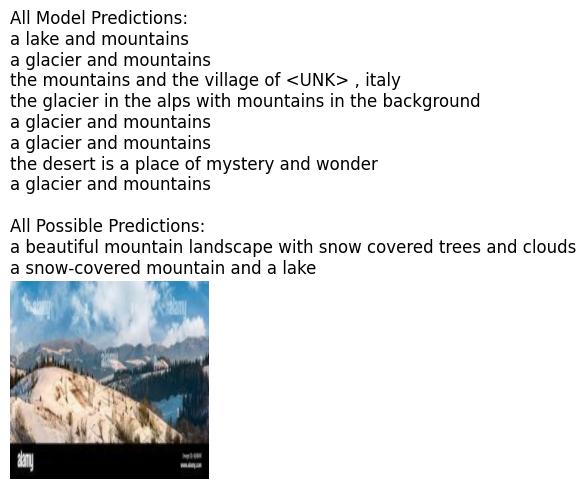

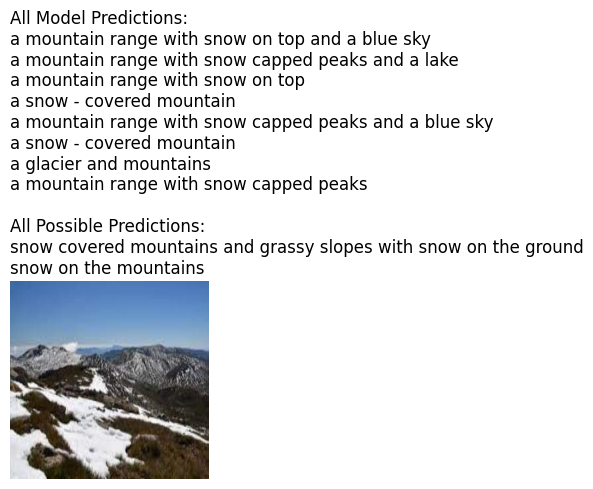

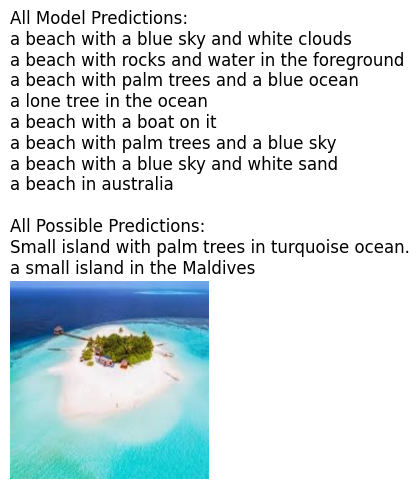

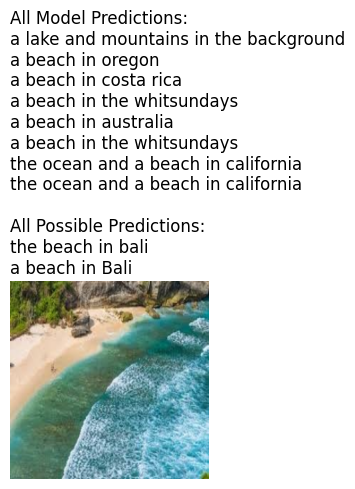

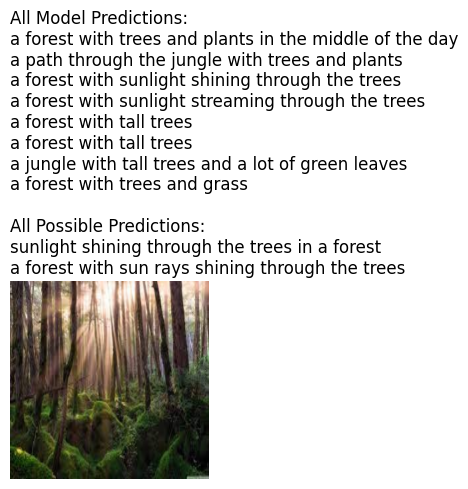

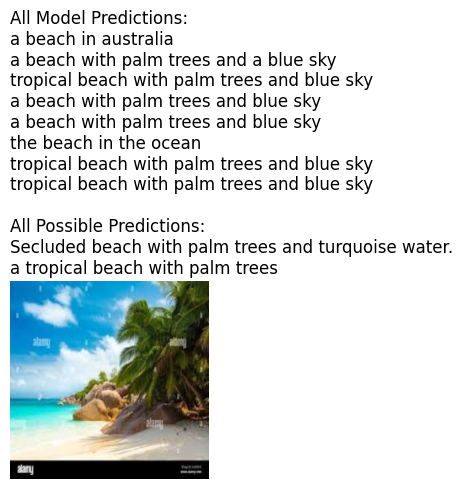

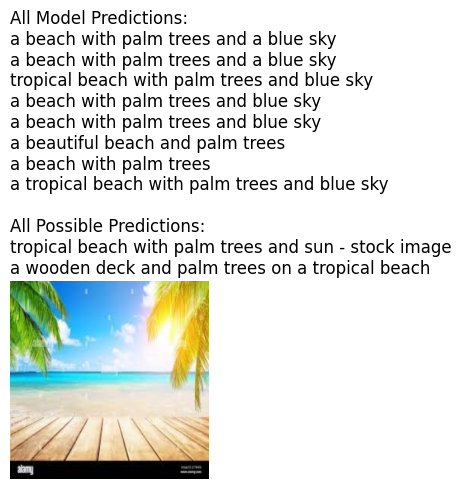

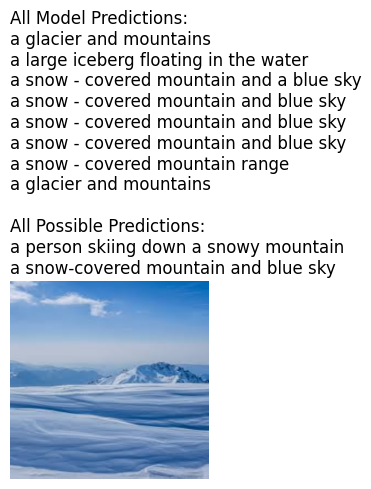

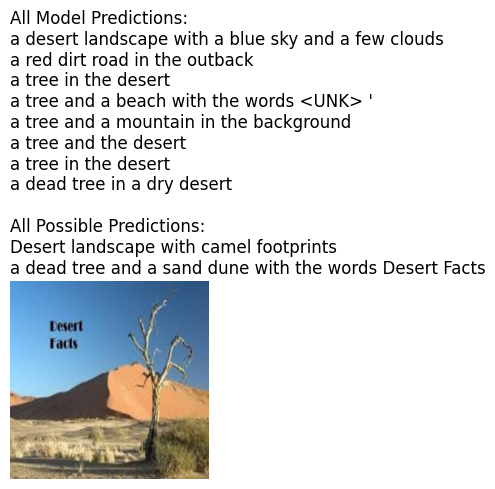

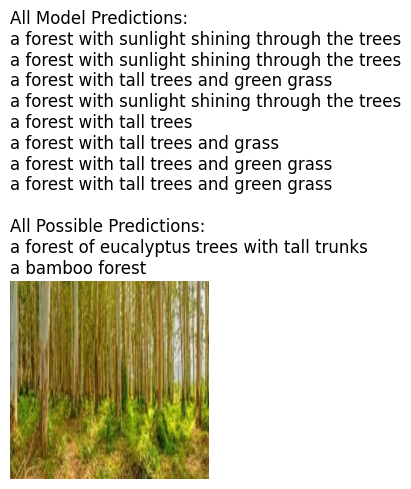

In [102]:
predictions = multiple_model_captions(
    model_list=model_list,
    dataloader=test_dataloader,
    vocabulary= test_dataset.vocab,
    device=device,
    mean=mean,
    std=std,
    num_batches=10,
    num_images=1,
    max_length=50,
    show_plot=True
)